In [1]:
from colorscheme import colors

In [2]:
import os
os.chdir(os.path.join('..', '..', '..'))
print(os.getcwd())

/Users/eharkin/Documents/projects/5HTGIF


In [3]:
import pickle

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.gridspec as gs
import pandas as pd
from ezephys import pltools

import sys
sys.path.append('./analysis/spk_timing/IA_mod')
import IAmod

from grr.Spiketrain import getSpikeLatency
from grr.Tools import reprint

In [4]:
IMG_PATH = os.path.join('figs', 'ims', 'writeup', 'fig1')
NOTEBOOK_PATH = os.path.join('figs', 'scripts', 'writeup')

plt.style.use(os.path.join(NOTEBOOK_PATH, 'publication_figure_style.dms'))

# Create toy models

In [14]:
ga = 20
tau_h = 1.0
input_strength = 40.2
Vinput = np.empty((10000, 1))
step_index = 3000
burn_index = 2000  # Burn in period in indices
Vinput[step_index:] = input_strength

toy_IA_neuron = IAmod.IAmod(ga, tau_h, 0)
toy_IA_neuron.vreset = -60.
toy_knockdown_neuron = IAmod.IAmod(ga * 0.5, tau_h, 0)
toy_knockdown_neuron.vreset = -60.
toy_ohmic_neuron = IAmod.IAmod(0, tau_h, 0)
toy_ohmic_neuron.vreset = -60.

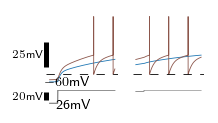

In [15]:
pre_pulse = {
    'lo': -70.,
    'hi': -55.
}

IMG_PATH = None#'./figs/ims/defence/'

spec_model = gs.GridSpec(2, 2, height_ratios = [1, 0.2], hspace = 0.1)

fig = plt.figure(figsize = (1.7, 1))

### A: simulated proof-of-principle

V_ax_lo = plt.subplot(spec_model[0, 0])
I_ax_lo = plt.subplot(spec_model[1, 0])

# Simulations without depolarizing pre-pulse
Vinput[:step_index] = toy_IA_neuron.ss_clamp(pre_pulse['lo'])

V_mat_IA, spks_mat, _, _ = toy_IA_neuron.simulate(pre_pulse['lo'], Vinput)
V_mat_IA[spks_mat] = 0
V_ax_lo.plot(V_mat_IA[burn_index:], '-', color=colors['ser'])
I_ax_lo.plot(Vinput[burn_index:], color=colors['input'])

V_mat_ohmic, spks_mat, _, _ = toy_knockdown_neuron.simulate(pre_pulse['lo'], Vinput)
V_mat_ohmic[spks_mat] = 0
V_ax_lo.plot(V_mat_ohmic[burn_index:], '-', color=colors['4AP'])
I_ax_lo.plot(Vinput[burn_index:], color = 'gray')

V_ax_hi = plt.subplot(spec_model[0, 1])
I_ax_hi = plt.subplot(spec_model[1, 1])

# Simulations with depolarizing pre-pulse
Vinput[:step_index] = toy_IA_neuron.ss_clamp(pre_pulse['hi'])

V_mat_IA, spks_mat, _, _ = toy_IA_neuron.simulate(pre_pulse['hi'], Vinput)
V_mat_IA[spks_mat] = 0
V_ax_hi.plot(V_mat_IA[burn_index:], '-', color=colors['ser'])
V_ax_hi.set_ylim(V_ax_lo.get_ylim())
I_ax_hi.plot(Vinput[burn_index:], color = colors['input'])
I_ax_hi.set_ylim(I_ax_lo.get_ylim())

V_mat_ohmic, spks_mat, _, _ = toy_knockdown_neuron.simulate(pre_pulse['hi'], Vinput)
V_mat_ohmic[spks_mat] = 0
V_ax_hi.plot(V_mat_ohmic[burn_index:], '-', color=colors['4AP'])
#I_ax_hi.plot(Vinput[burn_index:], color = colors['input'])

V_ax_lo.axhline(-60, color = 'k', ls = '--', lw = 0.5, dashes = (10, 10))
V_ax_lo.annotate('$-60$mV', (5000, -70), ha = 'right')

V_ax_hi.axhline(-60, color = 'k', ls = '--', lw = 0.5, dashes = (10, 10))
#V_ax_hi.annotate('$-60$mV', (5000, -68), ha = 'right')

I_ax_lo.annotate('26mV', (5000, 24), ha = 'right', va = 'top')
#I_ax_hi.annotate('26mV', (5000, 24), ha = 'right', va = 'top')

pltools.add_scalebar(ax = V_ax_lo, y_units = 'mV', omit_x = True, anchor = (0, 0.2), y_label_space = (0.05))
pltools.add_scalebar(ax = I_ax_lo, y_units = 'mV', omit_x = True, anchor = (0, 0.2), y_label_space = (0.05))
pltools.hide_border(ax = V_ax_lo)
pltools.hide_ticks(ax = V_ax_lo)
pltools.hide_border(ax = I_ax_lo)
pltools.hide_ticks(ax = I_ax_lo)

#pltools.add_scalebar(ax = ax_ohmic, y_units = 'mV', omit_x = True, anchor = (-0.05, 0), y_label_space = (-0.05))
pltools.hide_border(ax = V_ax_hi)
pltools.hide_ticks(ax = V_ax_hi)
pltools.hide_border(ax = I_ax_hi)
pltools.hide_ticks(ax = I_ax_hi)

In [18]:
input_strength = 40.2
Vinput = np.empty((20000, 1))
step_index = 3000
Vinput[step_index:] = input_strength
dt = 1e-3

latency_data = {
    'IA_V0': [],
    'IA_latency': [],
    'knockdown_V0': [],
    'knockdown_latency': [],
    'ohmic_V0': [],
    'ohmic_latency': []
}
for V0 in np.linspace(-90, -40, 10):
    reprint('Running simulations for V0 = {}'.format(V0))
    
    Vinput[:step_index] = toy_IA_neuron.ss_clamp(V0)
    
    for mod, latency_label, V0_label in zip(
        [toy_IA_neuron, toy_knockdown_neuron, toy_ohmic_neuron], 
        ['IA_latency', 'knockdown_latency', 'ohmic_latency'], 
        ['IA_V0', 'knockdown_V0', 'ohmic_V0']
    ):
        V_mat, spks_mat, _, _ = mod.simulate(V0, Vinput, dt=1e-3)
        latency_data[latency_label].append(
            getSpikeLatency(
                spks_mat.flatten().astype(np.float16), step_index * 1e-3, threshold=0.5, dt=dt
            )
        )
        latency_data[V0_label].append(V_mat.flatten()[(step_index - 100):step_index].mean())

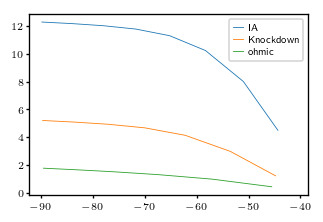

In [19]:
plt.plot(latency_data['IA_V0'], latency_data['IA_latency'], label= 'IA')
plt.plot(latency_data['knockdown_V0'], latency_data['knockdown_latency'], label='Knockdown')
plt.plot(latency_data['ohmic_V0'], latency_data['ohmic_latency'], label='ohmic')
plt.legend()

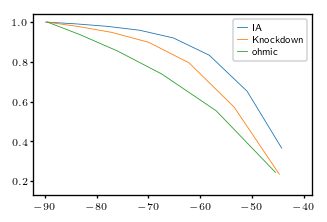

In [20]:
plt.plot(latency_data['IA_V0'], latency_data['IA_latency'] / np.nanmax(latency_data['IA_latency']), label= 'IA')
plt.plot(latency_data['knockdown_V0'], latency_data['knockdown_latency'] / np.nanmax(latency_data['knockdown_latency']), label='Knockdown')
plt.plot(latency_data['ohmic_V0'], latency_data['ohmic_latency'] / np.nanmax(latency_data['ohmic_latency']), label='ohmic')
plt.legend()

NameError: name 'toy_spk_predictor' is not defined

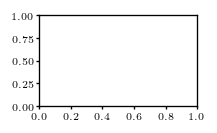

In [13]:
plt.figure(figsize=(1.7, 1))

plt.subplot(111)
#plt.title('\\textbf{{A3}} Effect on spike latency', loc = 'left')
V0_vec = np.linspace(-90, -45)
IA_spk_times = []
ohmic_spk_times = []
for V0 in V0_vec:
    IA_spk_times.append(
        toy_spk_predictor.predict_spk(ga, -45, V0, input_strength, 3, max_time = 10)
    )
    ohmic_spk_times.append(
        toy_spk_predictor.predict_spk(0, -45, V0, input_strength, 3, max_time = 10)
    )

plt.plot(V0_vec, ohmic_spk_times, 'k-', label = 'Linear model')
plt.plot(V0_vec, IA_spk_times, 'b-', label = 'Linear + $I_A$')
plt.ylabel('Spike latency $\\tau_{{\mathrm{{mem}}}}$')
plt.xlabel('$V_{{\mathrm{{pre}}}}$ (mV)')
plt.legend()
pltools.hide_border('tr')


if IMG_PATH is not None:
    plt.savefig(IMG_PATH + 'IA_experiment_predictions.png', dpi = 300)

plt.show()

